In [68]:
# Initial imports
import pandas as pd
import joblib as jl
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import pydotplus
from IPython.display import Image

In [30]:
# Read the CSV file into a Pandas DataFrame
passengers_df = pd.read_csv(
    Path('../CSV_OUTPUT/Base_Cleaned_DS_CSV.csv')   
)

# Review the DataFrame
passengers_df.head()

,Passenger Id,Title,First Name,Last Name,Sex,Age,Sibling/Spouse Abroad,Parent/Children Abroad,Passenger Class,Fare,Embarkation Port,Survival Boat,Body Number,Survived,age_group,family_size
0,1,Miss,Elisabeth Walton,Allen,female,29.0000,0,0,1,211.3375,S,2,S,1,Adults,0
1,2,Master,Hudson Trevor,Allison,male,0.9167,1,2,1,151.5500,S,11,S,1,Children,3
2,3,Miss,Helen Loraine,Allison,female,2.0000,1,2,1,151.5500,S,DNS,BNR,0,Children,3
3,4,Mr,Hudson Joshua Creighton,Allison,male,30.0000,1,2,1,151.5500,S,DNS,135.0,0,Adults,3
4,5,Mrs,Hudson J C (Bessie Waldo Daniels),Allison,female,25.0000,1,2,1,151.5500,S,DNS,BNR,0,Adults,3


## Preprocessing

In [31]:
# Drop the non-beneficial columns "Passenger Id", "First Name", "Last Name", "Body Number" and "Survival Boat"
passengers_df_cleaned = passengers_df.drop(columns = ["Passenger Id", "First Name", "Last Name", "Body Number",
                                                      "Survival Boat"])
passengers_df_cleaned.head()

,Title,Sex,Age,Sibling/Spouse Abroad,Parent/Children Abroad,Passenger Class,Fare,Embarkation Port,Survived,age_group,family_size
0,Miss,female,29.0000,0,0,1,211.3375,S,1,Adults,0
1,Master,male,0.9167,1,2,1,151.5500,S,1,Children,3
2,Miss,female,2.0000,1,2,1,151.5500,S,0,Children,3
3,Mr,male,30.0000,1,2,1,151.5500,S,0,Adults,3
4,Mrs,female,25.0000,1,2,1,151.5500,S,0,Adults,3


In [32]:
# Check data types
passengers_df_cleaned.dtypes

Title                      object
Sex                        object
Age                       float64
Sibling/Spouse Abroad       int64
Parent/Children Abroad      int64
Passenger Class             int64
Fare                      float64
Embarkation Port           object
Survived                    int64
age_group                  object
family_size                 int64
dtype: object

In [33]:
# Cast the columns "Age" to integer
passengers_df_cleaned["Age"] = passengers_df_cleaned["Age"].round().astype(int)
passengers_df_cleaned.dtypes

Title                      object
Sex                        object
Age                         int32
Sibling/Spouse Abroad       int64
Parent/Children Abroad      int64
Passenger Class             int64
Fare                      float64
Embarkation Port           object
Survived                    int64
age_group                  object
family_size                 int64
dtype: object

In [34]:
# Determine the number of unique values in each column
passengers_df_cleaned.nunique()

Title                      18
Sex                         2
Age                        73
Sibling/Spouse Abroad       7
Parent/Children Abroad      8
Passenger Class             3
Fare                      282
Embarkation Port            3
Survived                    2
age_group                   4
family_size                 9
dtype: int64

In [35]:
# Look at Titles value counts for binning
titles_vcount = passengers_df_cleaned["Title"].value_counts()
titles_vcount

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Major             2
 Mlle              2
 Jonkheer          1
 Don               1
 the Countess      1
 Lady              1
 Dona              1
 Sir               1
 Capt              1
 Mme               1
 Ms                1
Name: Title, dtype: int64

In [36]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
titles_to_replace = list(titles_vcount[titles_vcount < 10].index)

# Replace in dataframe
for title in titles_to_replace:
    passengers_df_cleaned['Title'] = passengers_df_cleaned['Title'].replace(title,"Other")

# Check to make sure binning was successful
passengers_df_cleaned['Title'].value_counts()

 Mr        757
 Miss      260
 Mrs       197
 Master     61
Other       33
Name: Title, dtype: int64

In [37]:
# Look at Titles age_group counts
passengers_df_cleaned["age_group"].value_counts()

Adults       1014
Teenagers     152
Children       99
Seniors        43
Name: age_group, dtype: int64

In [38]:
#Display the cleaned dataframe
passengers_df_cleaned.head()

,Title,Sex,Age,Sibling/Spouse Abroad,Parent/Children Abroad,Passenger Class,Fare,Embarkation Port,Survived,age_group,family_size
0,Miss,female,29,0,0,1,211.3375,S,1,Adults,0
1,Master,male,1,1,2,1,151.5500,S,1,Children,3
2,Miss,female,2,1,2,1,151.5500,S,0,Children,3
3,Mr,male,30,1,2,1,151.5500,S,0,Adults,3
4,Mrs,female,25,1,2,1,151.5500,S,0,Adults,3


In [39]:
# Convert categorical data to numeric with `pd.get_dummies`
passengers_df_preprocessed = pd.get_dummies(passengers_df_cleaned)
passengers_df_preprocessed.head()

,Age,Sibling/Spouse Abroad,Parent/Children Abroad,Passenger Class,Fare,Survived,family_size,Title_ Master,Title_ Miss,Title_ Mr,...,Title_Other,Sex_female,Sex_male,Embarkation Port_C,Embarkation Port_Q,Embarkation Port_S,age_group_Adults,age_group_Children,age_group_Seniors,age_group_Teenagers
0,29,0,0,1,211.3375,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
1,1,1,2,1,151.5500,1,3,1,0,0,...,0,0,1,0,0,1,0,1,0,0
2,2,1,2,1,151.5500,0,3,0,1,0,...,0,1,0,0,0,1,0,1,0,0
3,30,1,2,1,151.5500,0,3,0,0,1,...,0,0,1,0,0,1,1,0,0,0
4,25,1,2,1,151.5500,0,3,0,0,0,...,0,1,0,0,0,1,1,0,0,0


## Create a Random Forest Model with the Original Data

In [40]:
# Split our preprocessed data into our features and target arrays
y = passengers_df_preprocessed.Survived
X = passengers_df_preprocessed.drop(columns="Survived")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, stratify=y)

In [41]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [42]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [43]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [44]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [45]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [46]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,167,35
Actual 1,42,83


Accuracy Score : 0.764525993883792
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       202
           1       0.70      0.66      0.68       125

    accuracy                           0.76       327
   macro avg       0.75      0.75      0.75       327
weighted avg       0.76      0.76      0.76       327



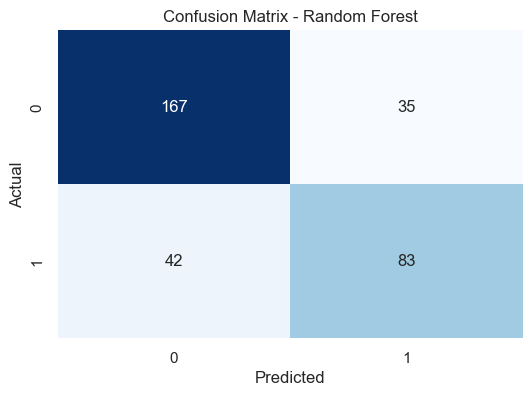

In [53]:
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

# Create a heatmap for the confusion matrix to make it visually appealing:
plt.figure(figsize=(6, 4))
sns.set(font_scale=1)  # Adjust font size if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [54]:
# Print the classification report with style
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       202
           1       0.70      0.66      0.68       125

    accuracy                           0.76       327
   macro avg       0.75      0.75      0.75       327
weighted avg       0.76      0.76      0.76       327



In [55]:
# Save the model to a file
jl.dump(rf_model, 'OUTPUT/random_forest_model.pkl')

['OUTPUT/random_forest_model.pkl']

In [56]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2572703656246304, 'Fare'),
 (0.20469939722195, 'Age'),
 (0.09364949062865596, 'Title_ Mr'),
 (0.07474071747915496, 'Sex_female'),
 (0.07260434688542305, 'Passenger Class'),
 (0.0703934625556186, 'Sex_male'),
 (0.050783545994583304, 'family_size'),
 (0.032889552475474385, 'Sibling/Spouse Abroad'),
 (0.026715865280439916, 'Title_ Mrs'),
 (0.022377639630950727, 'Parent/Children Abroad'),
 (0.019685339591139574, 'Title_ Miss'),
 (0.017985358890919317, 'Embarkation Port_C'),
 (0.014574802713677521, 'Embarkation Port_S'),
 (0.009137094903047932, 'age_group_Adults'),
 (0.007612267288439134, 'age_group_Children'),
 (0.006636952973986907, 'Embarkation Port_Q'),
 (0.0065748546590056545, 'age_group_Teenagers'),
 (0.004999150242227831, 'Title_ Master'),
 (0.004045066351738492, 'Title_Other'),
 (0.0026247286089363334, 'age_group_Seniors')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

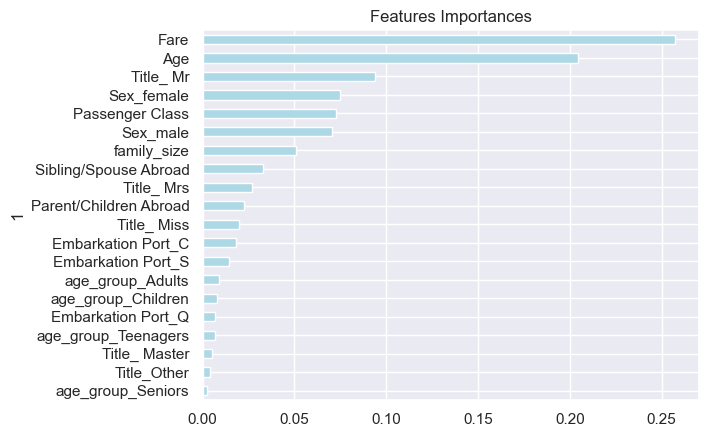

In [57]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightblue', title= 'Features Importances', legend=False)

## Create a Random Forest Model with Resampled Training Data
### Optimization attempt

In [71]:
# Count the distinct values of the labels data
y.value_counts()

0    808
1    500
Name: Survived, dtype: int64

In [72]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros_model = RandomOverSampler(random_state = 1)

# Fit the original training data to the random_oversampler model
X_resampled, y_resampled = ros_model.fit_resample(X_train, y_train)

In [73]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()

0    606
1    606
Name: Survived, dtype: int64

In [74]:
# Create a random forest classifier
# Assign a random_state parameter of 1 to the model
rf_resampled_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fit the model using the resampled training data
rf_resampled_model.fit(X_resampled, y_resampled)

# Make a prediction using the testing data
rf_resampled_predictions = rf_resampled_model.predict(X_test)

In [75]:
# Calculating the confusion matrix
cm_resampled = confusion_matrix(y_test, rf_resampled_predictions)
cm_resampled_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score_resampled = accuracy_score(y_test, rf_resampled_predictions)

In [76]:
# Displaying results
print("Confusion Matrix")
display(cm_resampled_df)
print(f"Accuracy Score : {acc_score_resampled}")
print("Classification Report")
print(classification_report(y_test, rf_resampled_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,167,35
Actual 1,42,83


Accuracy Score : 0.7767584097859327
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       202
           1       0.70      0.73      0.71       125

    accuracy                           0.78       327
   macro avg       0.76      0.77      0.77       327
weighted avg       0.78      0.78      0.78       327



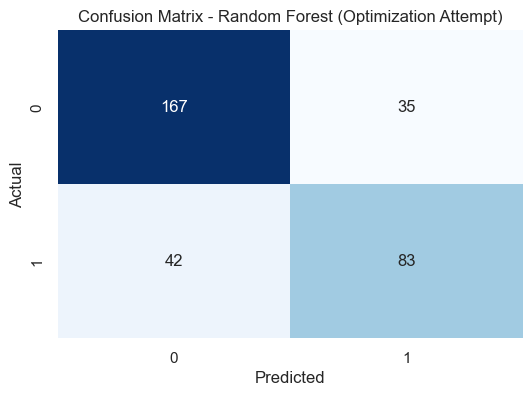

In [79]:
cm_resampled = confusion_matrix(y_test, rf_resampled_predictions)
report_resampled = classification_report(y_test, rf_resampled_predictions)

# Create a heatmap for the confusion matrix to make it visually appealing:
plt.figure(figsize=(6, 4))
sns.set(font_scale=1)  # Adjust font size if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Optimization Attempt)')
plt.show()

In [80]:
# Print the classification report with style
print("Classification Report:")
print(report_resampled)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       202
           1       0.70      0.73      0.71       125

    accuracy                           0.78       327
   macro avg       0.76      0.77      0.77       327
weighted avg       0.78      0.78      0.78       327



In [ ]:
# Save the model to a file
jl.dump(rf_model, 'OUTPUT/random_forest_model_resampled.pkl')